In [5]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg

In [6]:
x = np.array([1., 2., 3.,
              # 3.,
              4., 5., 6.])
y = np.array([3., 4., 2.,
              # 2.,
              6., 7., 5.])

breaks = np.array([1., 3., 6.])

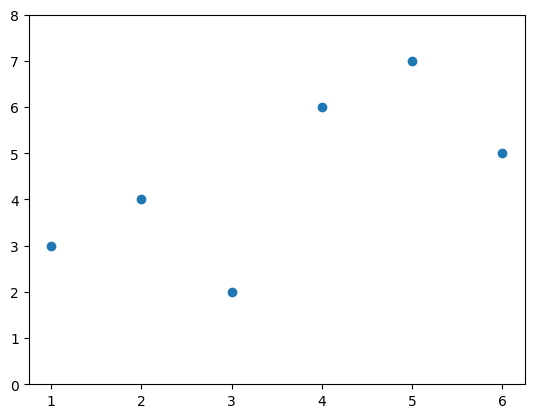

In [7]:
fig, ax = plt.subplots()
ax.plot(x, y, "o")
ax.set_ylim((0, 8))
plt.show()

In [50]:
import numbers


def _assemble_regression_matrix_2(X, breaks, degree=1, continuity=1):
    breaks = np.sort(breaks)
    if isinstance(degree, numbers.Number):
        degree = [degree] * (len(breaks) - 1)
    if continuity is not None and isinstance(continuity, numbers.Number):
        continuity = [continuity]

    Acols = []
    bins = np.digitize(X, breaks).clip(None, len(breaks) - 1)
    for i, d in enumerate(degree):
        for k in range(0, d + 1):
            Acols.append(np.where(bins == i+1, X ** k, 0.))

    A = np.column_stack(Acols)
    if continuity is None:
        return A



In [51]:
A = _assemble_regression_matrix_2(x, [1., 3.5, 6.], degree=2)
# A = np.array([[1., 1., 0., 0.],
#               [1., 2., 0., 0.],
#               [1., 3., 0., 0.],
#               # [0., 0., 1., 3.],
#               [0., 0., 1., 4.],
#               [0., 0., 1., 5.],
#               [0., 0., 1., 6.]])

In [52]:
A

array([[ 1.,  1.,  1.,  0.,  0.,  0.],
       [ 1.,  2.,  4.,  0.,  0.,  0.],
       [ 1.,  3.,  9.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  4., 16.],
       [ 0.,  0.,  0.,  1.,  5., 25.],
       [ 0.,  0.,  0.,  1.,  6., 36.]])

In [42]:
A.T @ A

array([[   3.,    6.,   14.,    0.,    0.,    0.],
       [   6.,   14.,   36.,    0.,    0.,    0.],
       [  14.,   36.,   98.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    3.,   15.,   77.],
       [   0.,    0.,    0.,   15.,   77.,  405.],
       [   0.,    0.,    0.,   77.,  405., 2177.]])

In [43]:
A.T @ y

array([  9.,  17.,  37.,  18.,  89., 451.])

In [88]:
beta = linalg.solve(A, y)

In [89]:
xx = np.linspace(1, 6, 1000)
AA = _assemble_regression_matrix_2(xx, breaks, degree=2)
yy = np.dot(AA, beta)

In [90]:
beta

array([ -1. ,   5.5,  -1.5, -28. ,  14.5,  -1.5])

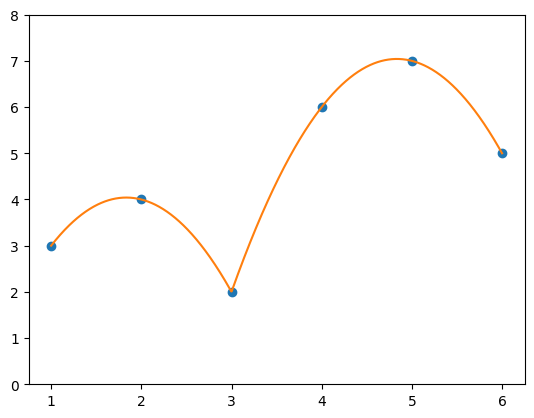

In [91]:
fig, ax = plt.subplots()
ax.plot(x, y, "o")
ax.plot(xx, yy, "-")
ax.set_ylim((0, 8))
plt.show()

In [116]:
import itertools
degrees = [0, 1]

h = []
for b, (d0, d1) in zip(breaks[1:-1], itertools.pairwise(degrees)):
    h.append(
        [b ** k for k in range(d0 + 1)] +
        [-1. * b ** k for k in range(d1 + 1)]
    )

print(np.array(h))

[[ 1. -1. -3.]]


In [102]:
C = np.array([[1., 3., 9., -1., -3., -9.],
              [0., 1., 6., 0., -1., -6.]])
Z = np.array([[0.], [0.]])

In [119]:
np.zeros((C.shape[0], 1))

array([[0.],
       [0.]])

In [78]:
_, m = A.shape
o, _ = C.shape

In [79]:
K = np.zeros((m + o, m + o))

In [80]:
K[:m, :m] = A.T @ A
K[:m, m:] = C.T
K[m:, :m] = C

In [81]:
z = np.zeros(m + o)
z[:m] = A.T @ y
z[m:] = Z.T

In [82]:
K

array([[ 3.000e+00,  6.000e+00,  1.400e+01,  0.000e+00,  0.000e+00,
         0.000e+00,  1.000e+00,  0.000e+00],
       [ 6.000e+00,  1.400e+01,  3.600e+01,  0.000e+00,  0.000e+00,
         0.000e+00,  3.000e+00,  1.000e+00],
       [ 1.400e+01,  3.600e+01,  9.800e+01,  0.000e+00,  0.000e+00,
         0.000e+00,  9.000e+00,  6.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  3.000e+00,  1.500e+01,
         7.700e+01, -1.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  1.500e+01,  7.700e+01,
         4.050e+02, -3.000e+00, -1.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  7.700e+01,  4.050e+02,
         2.177e+03, -9.000e+00, -6.000e+00],
       [ 1.000e+00,  3.000e+00,  9.000e+00, -1.000e+00, -3.000e+00,
        -9.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  1.000e+00,  6.000e+00,  0.000e+00, -1.000e+00,
        -6.000e+00,  0.000e+00,  0.000e+00]])

In [83]:
z

array([  9.,  17.,  37.,  18.,  89., 451.,   0.,   0.])

In [84]:
beta_prime = linalg.solve(K, z)
beta = beta_prime[:m]

In [85]:
xx = np.linspace(1, 6, 1000)
AA = _assemble_regression_matrix_2(xx, breaks, degree=2)
yy = np.dot(AA, beta)

In [86]:
beta

array([ 6.48905109, -4.23201251,  1.11835245, -9.47445255,  6.41032325,
       -0.65537018])

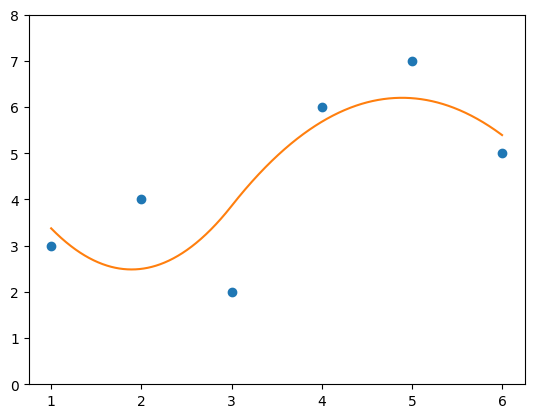

In [87]:
fig, ax = plt.subplots()
ax.plot(x, y, "o")
ax.plot(xx, yy, "-")
ax.set_ylim((0, 8))
plt.show()

In [49]:
_assemble_regression_matrix_2(x, breaks, degree=[0, 1])

1.0 0
3.0 1


array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 3.],
       [0., 1., 4.],
       [0., 1., 5.],
       [0., 1., 6.]])

In [195]:
A = np.array([[1., 0., 0.],
              [1., 0., 0.],
              [1., 0., 0.],
              [0., 1., 4.],
              [0., 1., 5.],
              [0., 1., 6.]])

In [199]:
beta = linalg.solve(A.T @ A, A.T @ y)

In [200]:
xx = np.linspace(1, 6, 1000)
AA = _assemble_regression_matrix_2(xx, breaks, degree=[0, 1])
yy = np.dot(AA, beta)

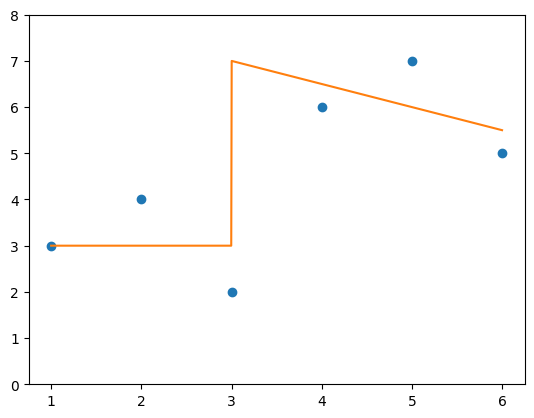

In [201]:
fig, ax = plt.subplots()
ax.plot(x, y, "o")
ax.plot(xx, yy, "-")
ax.set_ylim((0, 8))
plt.show()

In [202]:
C = np.array([[1., -1., -3.]])
Z = np.array([[0.]])

In [203]:
_, m = A.shape
o, _ = C.shape

In [204]:
K = np.zeros((m + o, m + o))

In [205]:
K[:m, :m] = A.T @ A
K[:m, m:] = C.T
K[m:, :m] = C

In [206]:
z = np.zeros(m + o)
z[:m] = A.T @ y
z[m:] = Z.T

In [207]:
K

array([[ 3.,  0.,  0.,  1.],
       [ 0.,  3., 15., -1.],
       [ 0., 15., 77., -3.],
       [ 1., -1., -3.,  0.]])

In [208]:
z

array([ 9., 18., 89.,  0.])

In [209]:
beta_prime = linalg.solve(K, z)
beta = beta_prime[:m]

In [210]:
beta

array([3.5, 0.5, 1. ])

In [219]:
xx = np.linspace(1, 6, 1000)
AA = _assemble_regression_matrix_2(xx, breaks, degree=[0, 1])
yy = np.dot(AA, beta)

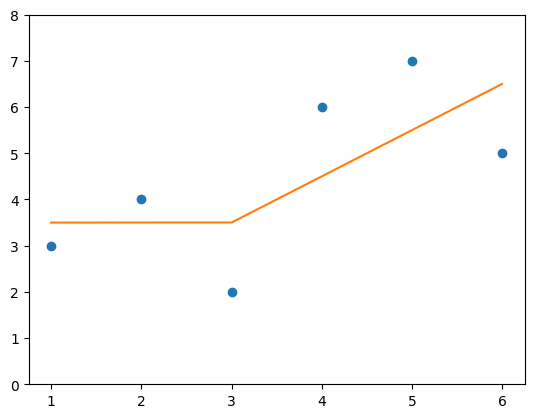

In [220]:
fig, ax = plt.subplots()
ax.plot(x, y, "o")
ax.plot(xx, yy, "-")
ax.set_ylim((0, 8))
plt.show()